### First attempt at building a Neural Network to learn a non-linear F(s)


In [2]:
import torch
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import seaborn as sns
import matplotlib.pyplot as plt


print(torch.__version__)

1.9.0


# Data Preprocessing

In [ ]:
df_geometric = pd.read_csv('../bricks_data/dataset_geometric.csv')
df_kitanidis = pd.read_csv('../bricks_data/dataset_kitanidis.csv')
train_df_geo, test_df_geo = train_test_split(df_geometric, test_size=0.33, random_state=44, shuffle=True)
train_df_kit, test_df_kit = train_test_split(df_kitanidis, test_size=0.33, random_state=44, shuffle=True)


In [ ]:
corrMatrix = df_kitanidis.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()


# Neural Network

### Defining The Dataset Class Inheriting from Torch.dataset to be able to use a dataloader for training

In [13]:
class DensitySurvey(Dataset):
    def __init__(self, df, galaxy_type, scaler=None):
        self.data = df
        # Extracting Targets and Input
        if galaxy_type == "LRG":
            self.target = self.data['lrg'].to_numpy(copy=True)
        if galaxy_type == "ELG":
            self.target = self.data['elg'].to_numpy(copy=True)
        if galaxy_type == "QSO":
            self.target = self.data['qso'].to_numpy(copy=True)
        self.input = self.data.drop(columns=['lrg','elg','qso']).to_numpy(copy=True)

        # Scaling, when scaler is passed (test-set) use the existing scaler
        self.scaler = scaler
        if self.scaler is None:
            self.scaler = preprocessing.MinMaxScaler()
            self.input = self.scaler.fit_transform(self.input)
            self.target = self.scaler.fit_transform(self.target.reshape(-1, 1))
        else:
            self.input = self.scaler.transform(self.input)
            self.target = self.scaler.transform(self.target.reshape(-1, 1))


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]).float(), torch.tensor(self.target[idx]).float()

    def __getscaler__(self):
        return self.scaler



In [14]:
df = pd.read_csv('../bricks_data/dataset_geometric.csv')
train_df, test_df = train_test_split(df, test_size=0.33, random_state=44, shuffle=True)
traindata = DensitySurvey(train_df, 'LRG')
testdata = DensitySurvey(test_df, 'LRG', scaler=traindata.__getscaler__())

ValueError: X has 17 features, but MinMaxScaler is expecting 1 features as input.

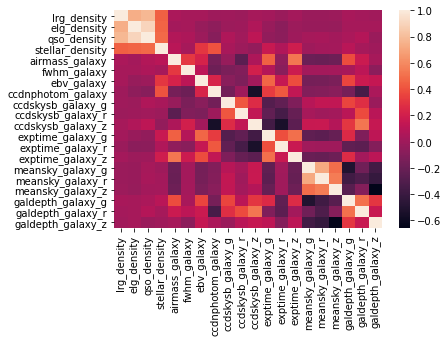

In [112]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()


In [115]:
print(df['lrg_density'].mean())
print(df['elg_density'].mean())
print(df['qso_density'].mean())

0.052414158315683405
0.1143583299637223
0.12564320203969445


In [ ]:
print(traindata.__len__())
print(testdata.__len__())

x,y = traindata.__getitem__(3)

print(x.dtype, y.dtype)

### Define Models and Hyperparameters



In [97]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_vars = 17, n_output_vars=1):
        super().__init__() # call constructor of superclass
        self.linear = nn.Linear(n_input_vars, n_output_vars)

    def forward(self, x):
        return self.linear(x)


device = 'cpu'
model = LinearRegression().to(device)



In [5]:
class Net(nn.Module):
    def __init__(self, n_feature = 17, n_hidden = 10, n_output = 1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_feature,n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = self.predict(out)
        return out

device = 'cpu'

model = Net().to(device)



In [6]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 500 #very low, but computational power not sufficient for more iterations
batch = 1024
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
time_start = time.time()

for epoch in range(no_epochs):
    loss_per_epoch = 0

    #loading the training data from trainset and shuffling for each epoch
    trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle = True)

    for i, batch_no in enumerate(trainloader, 0):

        #Put Model into train mode
        model.train()

        #Extract inputs and associated labels from dataloader batch
        inputs = batch_no[0].to(device)
        labels = batch_no[1].to(device)

        #Zero-out the gradients before backward pass (pytorch stores the gradients)
        optimiser.zero_grad()

        #Predict outputs (forward pass)
        predictions =  model(inputs)

        #Compute Loss
        loss = criterion(predictions, labels)

        #Backpropagation
        loss.backward()

        #Perform one step of gradient descent
        optimiser.step()

        #Append loss to the general loss for this one epoch
        loss_per_epoch += loss.item()
    if epoch % 10 == 0:
        print("Loss for Epoch", epoch, ": ", loss_per_epoch)

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed/60:.5} minutes ({time_passed:.3} seconds) taken to train the model")


NameError: name 'traindata' is not defined

In [107]:
model.eval()
y_pred = np.array([])
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch, shuffle=False)


for batch_no in testloader:

    #Split dataloader
    inputs = batch_no[0].to(device)
    labels = batch_no[1].to(device)

    #Forward pass through the trained network
    outputs = model(inputs)

    #Get predictions and append to label array + count number of correct and total
    y_pred = np.append(y_pred, outputs.detach().numpy())

y_gold = testdata.target

In [108]:
print(metrics.r2_score(y_gold, y_pred))
print(metrics.mean_squared_error(y_gold, y_pred))


-0.3737632813384124
0.008370131576093811
